Demo notebook for autoencoder

Arthur McCray  
Last remembered to update this line: 7/20/25

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import quantem as em
import torch
from quantem.core import config
from quantem.core.ml.autoencoder import ConvAutoencoder2d
from quantem.core.visualization import show_2d
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary
from tqdm.auto import tqdm

config.set({"device": "cuda:3"})
print(config.get("device"))


cuda:3


# Initialization

In [3]:
input_channels = 1  # 1 for a greyscale image, 3 for RGB, 4 for RGBA, etc.
image_shape = (256, 256)  # shape of the image input (same as output) (height, width)
shape = (input_channels, *image_shape)
start_filters = 16
latent_dim = 64
num_layers = 3
num_per_layer = 2
dtype = torch.float32
dropout = 0

model = ConvAutoencoder2d(
    input_size=image_shape,
    start_filters=start_filters,
    latent_dim=latent_dim,
    num_layers=num_layers,
    num_per_layer=num_per_layer,
    dtype=dtype,
    dropout=dropout,
)

batch_size = 5
input_shape = (batch_size, *shape)
t_inp = torch.rand(*input_shape, dtype=dtype)

t_out, latent_repr = model.forward(t_inp)
# forward is equivalent to 
# latent = model.encode(t_inp)
# t_out = model.decode(latent)
# return t_out, latent
print(f"in/out shapes (batch size = {batch_size}): {t_inp.shape} -> {t_out.shape} and latent shape: {latent_repr.shape}")
print(t_inp.dtype, t_out.dtype, latent_repr.dtype)

in/out shapes (batch size = 5): torch.Size([5, 1, 256, 256]) -> torch.Size([5, 1, 256, 256]) and latent shape: torch.Size([5, 64])
torch.float32 torch.float32 torch.float32


In [4]:
summary(model, shape, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
              ReLU-3         [-1, 16, 256, 256]               0
              ReLU-4         [-1, 16, 256, 256]               0
              ReLU-5         [-1, 16, 256, 256]               0
              ReLU-6         [-1, 16, 256, 256]               0
              ReLU-7         [-1, 16, 256, 256]               0
       BatchNorm2d-8         [-1, 16, 256, 256]              32
            Conv2d-9         [-1, 16, 256, 256]           2,320
             ReLU-10         [-1, 16, 256, 256]               0
             ReLU-11         [-1, 16, 256, 256]               0
             ReLU-12         [-1, 16, 256, 256]               0
             ReLU-13         [-1, 16, 256, 256]               0
             ReLU-14         [-1, 16, 2

# Training
- Py4DSTEM polycrystalline WS2 can be downloaded [here](https://drive.google.com/file/d/1AWB3-UTPiTR9dgrEkNFD7EJYsKnbEy0y/view?usp=sharing) 

In [5]:
f_data = Path("~/data/example_data/polycrystal_2D_WS2.h5").expanduser()
print(f_data.exists())

True


keys:  ['4DSTEM', 'datacube', 'data']
(128, 128, 128, 128)


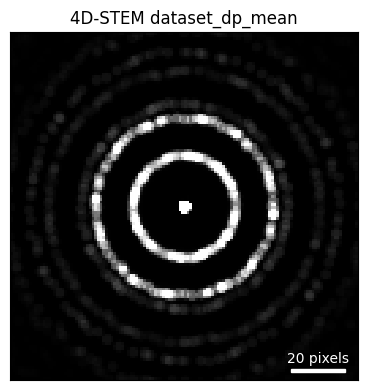

In [6]:
dset = em.io.read_emdfile_to_4dstem(str(f_data), data_keys=["4DSTEM", "datacube", "data"], calibration_keys=["4DSTEM", "datacube", "calibration"])
dset.units = ['pixels'] * 4 
dset.sampling = [1]*4
dset.get_dp_mean()
dset.get_dp_max()
dset.dp_mean.show()
print(dset.shape)

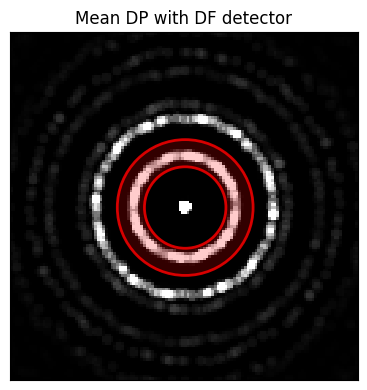

(<Figure size 600x600 with 1 Axes>, <Axes: title={'center': 'DF'}>)

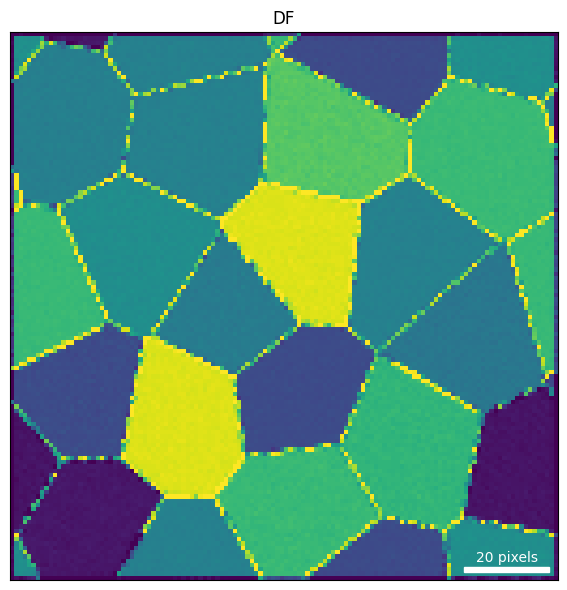

In [7]:
probe_qy0, probe_qx0 = dset.shape[2]//2, dset.shape[3]//2
dset.get_virtual_image(
    mode="annular",
    geometry=((probe_qy0, probe_qx0), (15, 25)), 
    name="DF",
    show=True,
)
dset.show_virtual_images(cmap='viridis')

In [8]:

def augment_dataset(
    images, labels, augment_factor=2, dose:float | tuple[float, float] = 1e6, rng=None, flip=True, rotate=True
):
    """
    Augment dataset with random rotations and flips.
    """
    if isinstance(dose, (int, float)):
        dose_range = [dose, dose]
    else:
        dose_range = dose
    augmented_images = []
    augmented_labels = []
    if rng is None:
        rng = np.random.default_rng()

    for img, lbl in tqdm(zip(images, labels), total=len(images)):
        for _ in range(augment_factor):
            img_aug = img.copy()
            lbl_aug = lbl.copy()
            if rotate:
                n_rot = int(rng.integers(0, 4))
                img_aug = np.rot90(img, k=n_rot, axes=(-2, -1))
                lbl_aug = np.rot90(lbl, k=n_rot, axes=(-2, -1))
            if flip:
                if rng.random() > 0.5:  # Random horizontal flip
                    img_aug = np.flip(img_aug, axis=-1)
                    lbl_aug = np.flip(lbl_aug, axis=-1)

                if rng.random() > 0.5:  # Random vertical flip
                    img_aug = np.flip(img_aug, axis=-2)
                    lbl_aug = np.flip(lbl_aug, axis=-2)

            if dose_range[1] > 0:
                rng_dose = rng.uniform(dose_range[0], dose_range[1])
                img_aug = noise_image_poisson(img_aug, dose=rng_dose, rng=rng)

            augmented_images.append(img_aug)
            augmented_labels.append(lbl_aug)

    augmented_images = np.stack(augmented_images, axis=0)  # (N, C, H, W)
    augmented_labels = np.stack(augmented_labels, axis=0)  # (N, H, W)

    return augmented_images, augmented_labels


def noise_image_poisson(image, dose=1e6, rng=None):
    """
    Add Poisson noise to an image.
    """
    if rng is None:
        rng = np.random.default_rng()
    
    image = image / image.sum(axis=(-2, -1))[...,None,None] * dose 
    noisy_image = rng.poisson(image).astype(image.dtype)

    return noisy_image



In [9]:
dps = dset.array.reshape((-1, *dset.shape[2:]))
print(dps.shape)

(16384, 128, 128)


In [10]:
rng = np.random.default_rng(42)
rng_torch = torch.Generator().manual_seed(42)
noisy_dps, _nonoise_labels = augment_dataset(dps, dps, augment_factor=1, dose=[1e5, 1e7], rng=rng) # dose should really be a range of values


  0%|          | 0/16384 [00:00<?, ?it/s]

/tmp/ipykernel_2388783/4110431271.py:3: RuntimeWarning: divide by zero encountered in log
  show_2d([np.log(noisy_dps[i]), np.log(_nonoise_labels[i])], cbar=True, title=['noisy', 'nonoise'])


(<Figure size 800x400 with 4 Axes>,
 array([<Axes: title={'center': 'noisy'}>,
        <Axes: title={'center': 'nonoise'}>], dtype=object))

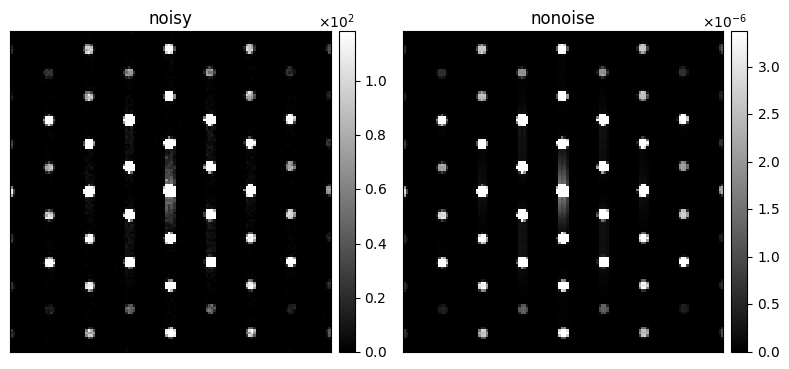

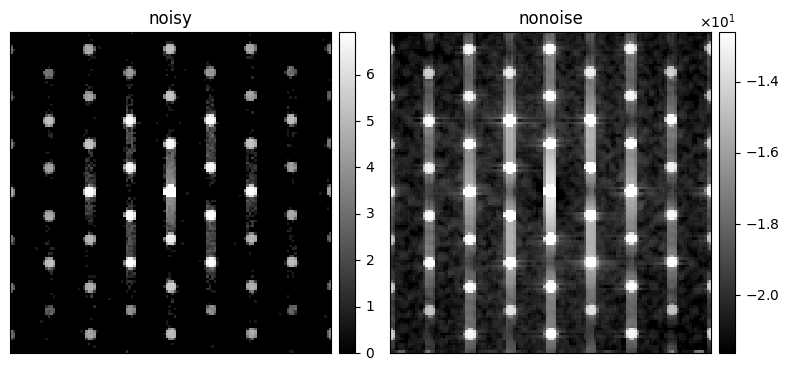

In [11]:
i = 15
show_2d([noisy_dps[i], _nonoise_labels[i]], cbar=True, title=['noisy', 'nonoise'])
show_2d([np.log(noisy_dps[i]), np.log(_nonoise_labels[i])], cbar=True, title=['noisy', 'nonoise'])

In [12]:
class SimpleDPAutoencoderDataset(Dataset):
    def __init__(self, dps):
        self.dps = [torch.log(torch.tensor(dp, dtype=torch.float32)+1) for dp in dps]

    def __len__(self):
        return len(self.dps)

    def __getitem__(self, idx):
        return self.dps[idx]



dataset = SimpleDPAutoencoderDataset(noisy_dps)

# Split into train and validation sets
val_factor = 0.2
train_size = int((1 - val_factor) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=rng_torch)

print(f"Length of train dataset: {len(train_dataset)} | validation dataset: {len(val_dataset)}")

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"Train loader batches: {len(train_loader)} | Validation loader batches: {len(val_loader)}")

Length of train dataset: 13107 | validation dataset: 3277
Train loader batches: 410 | Validation loader batches: 103


In [13]:
model = ConvAutoencoder2d(
    input_size=dataset[0].shape,
    start_filters=16,
    latent_dim=64,
    num_layers=3,
    dtype=torch.float32,
    dropout=0,
    latent_normalization="l2",
)

model = model.to(config.get("device"))

optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-5 * np.sqrt(batch_size)
)  # Adjust learning rate based on batch size
criterion = torch.nn.MSELoss()  

train_losses = []
val_losses = []

  0%|          | 0/20 [00:00<?, ?it/s]

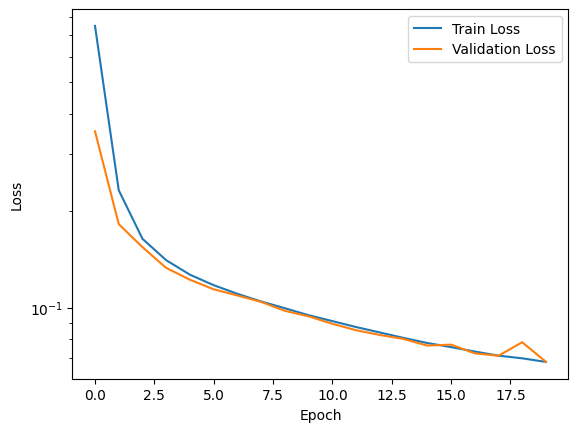

In [14]:
num_epochs = 20

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    for inputs in train_loader:
        inputs = inputs.to(config.get("device"))[:,None]

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(inputs, outputs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            inputs = batch[:,None]
            inputs = inputs.to(config.get("device"))

            outputs, _ = model(inputs)
            loss = criterion(inputs, outputs)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

fig, ax = plt.subplots()
ax.semilogy(train_losses, label="Train Loss")
ax.semilogy(val_losses, label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()


Our training set and validation sets are mixed in with each other, so this is def overtraining but we won't see a separation between the two curves. 

tensor(0.5184, device='cuda:3', grad_fn=<DotBackward0>)


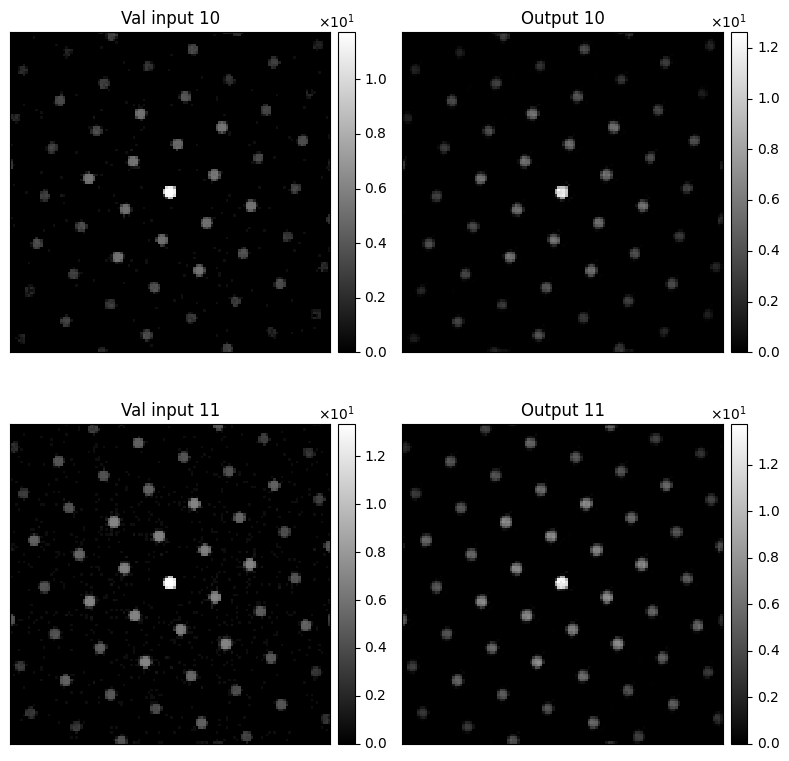

In [15]:
i = 10

inp1 = val_dataset[i]
out1, latent1 = model.forward(inp1[None, None, ...].to(config.get_device()))
out1 = out1.squeeze().cpu().detach().numpy()
inp2 = val_dataset[i+1]
out2, latent2 = model.forward(inp2[None, None, ...].to(config.get_device()))
out2 = out2.squeeze().cpu().detach().numpy()
show_2d(
    [
        [inp1.squeeze(),
        out1.squeeze(),],
        [inp2.squeeze(),
        out2.squeeze(),],
    ],
    cbar=True,
    norm="minmax",
    title=[
        [f"Val input {i}",
        f"Output {i}",],
        [f"Val input {i+1}",
        f"Output {i+1}",]
    ],
);
# print(latent1, latent2)
print(torch.dot(latent1.squeeze(), latent2.squeeze()))


In [16]:
dset_flat = dset.array.reshape((-1, *dset.shape[2:]))
dset_noisy = noise_image_poisson(dset_flat, dose=1e7, rng=rng)

Note we have to process/treat our test/experimental data the same as our training/val data. We took a log of our input data for training, and the dose for all of those was in the range of 1e5-1e7, if we don't do the same for our data here, the output values will be nonsense even though our model is correctly trained

In [17]:
dset_flat = np.log(dset.array.reshape((-1, *dset.shape[2:])) * 1e7 + 1)
dset_input = torch.tensor(dset_flat, dtype=torch.float32)

dset_features = [] 
batch_size = 100
for i in tqdm(range(0, len(dset_input), batch_size)):
    latent = model.encode(dset_input[i:i+batch_size][:,None].to(config.get("device")))
    dset_features.append(latent.cpu().detach().numpy().squeeze())
dset_features = np.concatenate(dset_features, axis=0)
dset_features = dset_features.reshape((*dset.shape[:2], -1))
dset_features.shape


  0%|          | 0/164 [00:00<?, ?it/s]

(128, 128, 64)

In [18]:
def marching_clusters(encoded_map, similarity_threshold=0.8):
    """
    super basic marching squares -- replace with better implementation 
    """
    Ry, Rx, latent_dim = encoded_map.shape
    labels = np.zeros((Ry, Rx), dtype=int)
    current_label = 1
    
    for i in range(Ry):
        for j in range(Rx):
            if labels[i, j] == 0:  # Unvisited pixel
                # Start new region from this seed
                seed_vector = encoded_map[i, j]
                region_mask = grow_region(encoded_map, seed_vector, 
                                        (i, j), similarity_threshold)
                labels[region_mask] = current_label
                current_label += 1
    
    return labels

def grow_region(encoded_map, seed_vector, start_pos, threshold):
    """Grow region based on cosine similarity in latent space"""
    from collections import deque
    
    Ry, Rx, _ = encoded_map.shape
    visited = np.zeros((Ry, Rx), dtype=bool)
    region_mask = np.zeros((Ry, Rx), dtype=bool)
    
    queue = deque([start_pos])
    visited[start_pos] = True
    
    while queue:
        x, y = queue.popleft()
        
        current_vector = encoded_map[x, y]
        
        seed_norm = np.linalg.norm(seed_vector)
        current_norm = np.linalg.norm(current_vector)
        
        if seed_norm > 0 and current_norm > 0:
            similarity = np.dot(seed_vector, current_vector) / (seed_norm * current_norm)
        else:
            similarity = 1.0 if seed_norm == current_norm == 0 else 0.0
        
        if similarity > threshold:
            region_mask[x, y] = True
            
            # Add 4-connected neighbors
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                nx, ny = x + dx, y + dy
                if (0 <= nx < Ry and 0 <= ny < Rx and 
                    not visited[nx, ny]):
                    visited[nx, ny] = True
                    queue.append((nx, ny))
    
    return region_mask

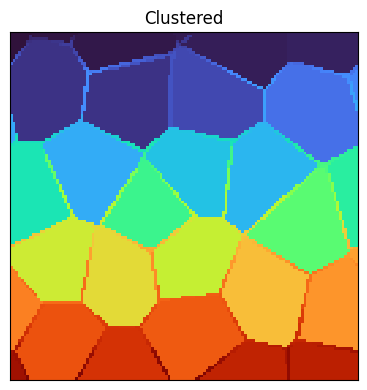

In [25]:
clustered = marching_clusters(dset_features, 0.95)
show_2d(clustered, title="Clustered", cmap='turbo', norm="minmax");